<a href="https://colab.research.google.com/github/MarcosLaydner/ds_repo/blob/master/Assignment_2/Titanic_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing and comparing Learn++.NSE and drifting-feature-removal on Titanic Datase

## Imports and Enviroment preparation

In [0]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from zipfile import ZipFile
import matplotlib.pyplot as plt

!pip install -U scikit-multiflow
from skmultiflow.meta import LearnNSE

Requirement already up-to-date: scikit-multiflow in /usr/local/lib/python3.6/dist-packages (0.4.1)


In [0]:
# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file if needed
# uploaded = files.upload()

# moves json file so the download commands works properly
# !cp kaggle.json ~/.kaggle/kaggle.json

# Or alternatively, type your credentials into the following variables
os.environ['KAGGLE_USERNAME'] = "user" # username from the json file
os.environ['KAGGLE_KEY'] = "key" # key from the json file

# Dataset download, storage and preprocessing

In [0]:
!kaggle competitions download -c titanic

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
def missing_data_treatment(data):
  for i in data.columns:
    if data[i].dtype == 'object':
      data[i] = data[i].fillna(data[i].mode().iloc[0])
    if (data[i].dtype == 'int' or data[i].dtype == 'float'):
      data[i] = data[i].fillna(np.mean(data[i]))

def label_encoding(data, encoder):
  for i in data.columns:
    if (data[i].dtype == 'object'):
      data[i] = encoder.fit_transform(data[i].astype('str'))
      data[i] = data[i].astype('object')

In [0]:
missing_data_treatment(train)
missing_data_treatment(test)

number = LabelEncoder()
label_encoding(train, number)
label_encoding(test, number)

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,108,1,22.000000,1,0,523,7.2500,47,2
1,2,1,1,190,0,38.000000,1,0,596,71.2833,81,0
2,3,1,3,353,0,26.000000,0,0,669,7.9250,47,2
3,4,1,1,272,0,35.000000,1,0,49,53.1000,55,2
4,5,0,3,15,1,35.000000,0,0,472,8.0500,47,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,548,1,27.000000,0,0,101,13.0000,47,2
887,888,1,1,303,0,19.000000,0,0,14,30.0000,30,2
888,889,0,3,413,0,29.699118,1,2,675,23.4500,47,2
889,890,1,1,81,1,26.000000,0,0,8,30.0000,60,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


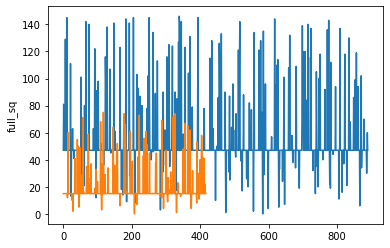

In [0]:
plt.subplot()
plt.plot(train.Cabin)
plt.ylabel('full_sq')
plt.subplot()
plt.plot(test.Cabin)
plt.ylabel('full_sq')
plt.show()

# Functions for checking Covariate Shift

In [0]:
def compare_train_test_distribution(train, test, col, bins):  
  N_points = 100000
  n_bins = bins

  x = train[col]
  y = test[col]

  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(x, bins=n_bins)
  axs[1].hist(y, bins=n_bins)

def concat(train_df, test_df, id_column, y):
  train_df.drop(columns=[id_column, y], inplace=True)
  test_df.drop(columns=[id_column], inplace=True)

  train_df['is_test'] = 0
  test_df['is_test'] = 1
  df = pd.concat([train_df, test_df], axis = 0)
  return df

def shuffle_split(df):
  X = df.drop(columns=['is_test'])
  y = df['is_test']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
  print('train2 shape:', X_train.shape, 'test2 shape:', X_test.shape)
  return X_train, X_test, y_train, y_test


def test_shift(X_train, X_test, y_train, y_test):
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)

  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

# Applying the functions to the data

train2 shape: (916, 10) test2 shape: (393, 10)
AUC score:  0.9949


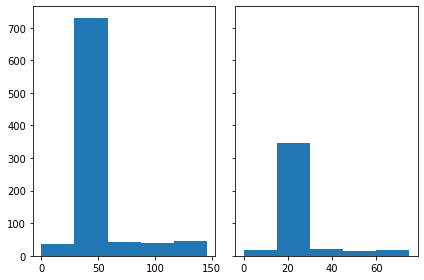

In [0]:
train_c = train.copy()
test_c = test.copy()

compare_train_test_distribution(train_c, test_c, 'Cabin', 5)

concat_df = concat(train_c, test_c, 'PassengerId', 'Survived')
param = shuffle_split(concat_df)

test_shift(param[0], param[1], param[2], param[3])


score of 1.0 indicating total shift

# Identifying problematic features

In [0]:
y = concat_df['is_test']
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in concat_df.columns:
  score = cross_val_score(model,pd.DataFrame(concat_df[i]),y,cv=2,scoring='roc_auc')
  if (np.mean(score) > 0.8):
    drop_list.append(i)
    print(i,np.mean(score))

drop_list.remove('is_test')
drop_list

Cabin 0.9814962453197583
is_test 1.0


['Cabin']

Only the Cabin feature has been identified as drifting

---

# Determining the importance of the drifting features

In [0]:
rf = RandomForestClassifier()
rf.fit(train.drop('Survived',axis=1),train['Survived'])
pred = rf.predict(test)
columns = ['Survived']
sub = pd.DataFrame(data=pred,columns=columns)
sub['PassengerId'] = test['PassengerId']
sub = sub[['PassengerId','Survived']]
sub.to_csv('with_drifting.csv', index=False)

!kaggle competitions submit -c titanic -f with_drifting.csv -m "With drifting"

100% 2.77k/2.77k [00:04<00:00, 664B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

Accuracy store is 0.76076

RMSE of the submitted model with drifting is 0.40540

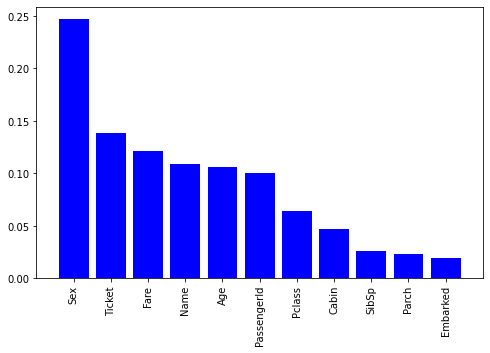

In [0]:
features = train.drop('Survived',axis=1).columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

This way, it is possible to conclude that the only drifting feature is not very important, and can be removed


## Testing the performance without the problem feature


In [0]:
drift_train = train.drop(columns=drop_list)
drift_test = test.drop(columns=drop_list)

rf = RandomForestClassifier(n_estimators=200, max_depth=6,max_features=10)
rf.fit(drift_train.drop('Survived',axis=1),train['Survived'])
pred = rf.predict(drift_test)
columns = ['Survived']
sub = pd.DataFrame(data=pred,columns=columns)
sub['PassengerId'] = test['PassengerId']
sub = sub[['PassengerId','Survived']]
sub.to_csv('without_drifting.csv', index=False)

!kaggle competitions submit -c titanic -f without_drifting.csv -m "without drifting"

100% 2.77k/2.77k [00:03<00:00, 895B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

The result is suprisingly lower, with an accuracy score of 0.75119


## Using Learn++.NSE


In [0]:
def learn_nse_method(train, test):
  learn_nse = LearnNSE()

  n_samples = 0
  correct_cnt = 0

  for i in range(len(train)):
    sample = train.iloc[[i]]
    X = sample.loc[:, train.columns != 'Survived']
    y = sample['Survived']
    
    y_pred = learn_nse.predict(X.to_numpy())

    if y.values[0] == y_pred[0]:
      correct_cnt += 1

    learn_nse = learn_nse.partial_fit(X.to_numpy(), y.to_numpy(), classes=[0, 1])
    n_samples += 1

  print('{} samples analyzed.'.format(n_samples))
  print('LearnPP.NSE accuracy: {}'.format(correct_cnt / n_samples))

  return learn_nse

In [0]:
learn_nse = learn_nse_method(train, test)

predictions = learn_nse.predict(test.to_numpy())
columns = ['Survived']
sub = pd.DataFrame(data=predictions,columns=columns)
sub['PassengerId'] = test['PassengerId']
sub = sub[['PassengerId','Survived']]
sub.to_csv('LearnSE.csv', index=False)

!kaggle competitions submit -c titanic -f LearnSE.csv -m "LearnSE"

891 samples analyzed.
LearnPP.NSE accuracy: 0.7250280583613917
100% 2.77k/2.77k [00:03<00:00, 895B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

The result for the Learn++.NSE method will all features is 0.75598, which is higher than the proposed method, but lower than the plain Random Forest Classifier

Using Learn++.NSE without drifting feature


In [0]:
drift_train = train.drop(columns=drop_list)
drift_test = test.drop(columns=drop_list)

learn_nse = learn_nse_method(drift_train, drift_test)

predictions = learn_nse.predict(drift_test.to_numpy())
columns = ['Survived']
sub = pd.DataFrame(data=predictions,columns=columns)
sub['PassengerId'] = drift_test['PassengerId']
sub = sub[['PassengerId','Survived']]
sub.to_csv('LearnSE_no_drift.csv', index=False)

!kaggle competitions submit -c titanic -f LearnSE_no_drift.csv -m "LearnSE without drift"

891 samples analyzed.
LearnPP.NSE accuracy: 0.7272727272727273
100% 2.77k/2.77k [00:03<00:00, 909B/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (9.1 hours from now).


Running Learn++.NSE withou the drifting feature resulted in the highest score, with an accuracy of 0.76555